In [161]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [162]:
from fastai.vision import *
import cv2 as cv

In [163]:
val_s_ids = []
with open("../VOCdevkit/VOC2007/ImageSets/Segmentation/val.txt") as file:
    val = file.read().splitlines()
for i in range(len(val)):
    x = int(val[i])
    val_s_ids.append(x)
val_s_ids[:3]

[39, 63, 121]

In [164]:
train_s_ids = []
with open("../VOCdevkit/VOC2007/ImageSets/Segmentation/train.txt") as file:
    train = file.read().splitlines()
for i in range(len(train)):
    x = int(train[i])
    train_s_ids.append(x)
train_s_ids[:3]

[32, 33, 42]

In [165]:
test_s_ids = []
with open("../VOCdevkit/VOC2007/ImageSets/Segmentation/test.txt") as file:
    test = file.read().splitlines()
for i in range(len(test)):
    x = int(test[i])
    test_s_ids.append(x)
test_s_ids[:3]

[68, 175, 243]

In [166]:
path = Path('../VOCdevkit/VOC2007')
path_img = path/'JPEGImages'
path_lbl = path/'SegmentationClass'

In [167]:
fnames = get_image_files(path_img)
fnames[:3]

[WindowsPath('../VOCdevkit/VOC2007/JPEGImages/000001.jpg'),
 WindowsPath('../VOCdevkit/VOC2007/JPEGImages/000002.jpg'),
 WindowsPath('../VOCdevkit/VOC2007/JPEGImages/000003.jpg')]

In [168]:
f_train_s = []
for i in range(len(train_s_ids)):
    img_f = fnames[train_s_ids[i]-1]
    f_train_s.append(img_f)
f_train_s[:3]

[WindowsPath('../VOCdevkit/VOC2007/JPEGImages/000032.jpg'),
 WindowsPath('../VOCdevkit/VOC2007/JPEGImages/000033.jpg'),
 WindowsPath('../VOCdevkit/VOC2007/JPEGImages/000042.jpg')]

In [169]:
f_val_s = []
for i in range(len(val_s_ids)):
    img_f = fnames[val_s_ids[i]-1]
    f_val_s.append(img_f)
f_val_s[:3]

[WindowsPath('../VOCdevkit/VOC2007/JPEGImages/000039.jpg'),
 WindowsPath('../VOCdevkit/VOC2007/JPEGImages/000063.jpg'),
 WindowsPath('../VOCdevkit/VOC2007/JPEGImages/000121.jpg')]

In [170]:
f_test_s = []
for i in range(len(test_s_ids)):
    img_f = fnames[test_s_ids[i]-1]
    f_test_s.append(img_f)
f_test_s[:3]

[WindowsPath('../VOCdevkit/VOC2007/JPEGImages/000068.jpg'),
 WindowsPath('../VOCdevkit/VOC2007/JPEGImages/000175.jpg'),
 WindowsPath('../VOCdevkit/VOC2007/JPEGImages/000243.jpg')]

In [171]:
codes = ['Background','Aeroplane','Bicycle','Bird','Boat','Bottle','Bus','Car','Cat','Chair','Cow','DinningTable','Dog','Horse','Motorbike','Person','PottedPlant','Sheep','Sofa','Train','TVMonitor']
len(codes)

21

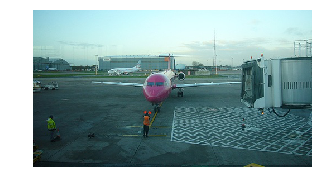

In [172]:
# open and show image
img_test =  open_image(f_train_s[0])
img_test.show(figsize=(5, 5))

In [173]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{".png"}'
get_y_fn(f_train_s[0])

WindowsPath('../VOCdevkit/VOC2007/SegmentationClass/000032.png')

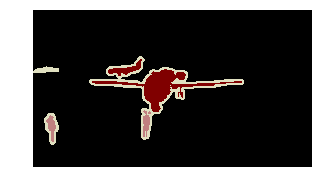

In [174]:
mask = open_image(get_y_fn(f_train_s[0]))
mask.show(figsize=(5, 5), alpha=1)

In [175]:
trainval_ids = f_train_s + f_test_s
trainval_lbl = []
for i in range(len(trainval_ids)):
    f = get_y_fn(trainval_ids[i])
    trainval_lbl.append(f)


In [176]:
src_size = np.array(mask.shape[1:])
size = 224
bs = 8
print(src_size)

[281 500]


In [177]:
with open("../VOCdevkit/VOC2007/ImageSets/Segmentation/val.txt") as file:
        f = file.read().splitlines()
newf = open("../VOCdevkit/VOC2007/ImageSets/Segmentation/valnew.txt","w")
for i in range(len(f_train_s)):
    if i != len(f_train_s)-1:
        newf.write(f[i]+'.jpg\n')
    else:
        newf.write(f[i]+'.jpg')
file.close()
newf.close()

In [178]:
f_val_s[:3]
list = SegmentationItemList(f_train_s+f_val_s)
src = (list
       .split_by_fname_file('../VOCdevkit/VOC2007/ImageSets/Segmentation/valnew.txt')
       .label_from_func(get_y_fn, classes=codes)
)
src


LabelLists;

Train: LabelList (213 items)
x: SegmentationItemList
Image (3, 281, 500),Image (3, 366, 500),Image (3, 335, 500),Image (3, 333, 500),Image (3, 500, 334)
y: SegmentationLabelList
ImageSegment (1, 281, 500),ImageSegment (1, 366, 500),ImageSegment (1, 335, 500),ImageSegment (1, 333, 500),ImageSegment (1, 500, 334)
Path: .;

Valid: LabelList (209 items)
x: SegmentationItemList
Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500),Image (3, 375, 500)
y: SegmentationLabelList
ImageSegment (1, 375, 500),ImageSegment (1, 375, 500),ImageSegment (1, 375, 500),ImageSegment (1, 375, 500),ImageSegment (1, 375, 500)
Path: .;

Test: None

In [179]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

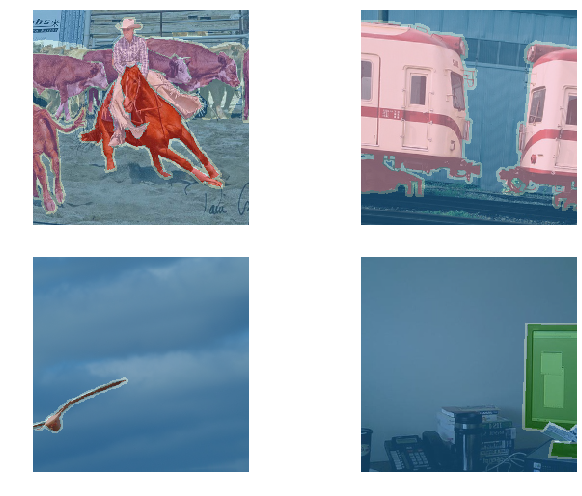

In [180]:
data.show_batch(rows=2, figsize=(10, 7))

In [181]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [182]:
learn = unet_learner(data, models.resnet34,metrics=acc_camvid)
learn

Learner(data=ImageDataBunch;

Train: LabelList (213 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: .;

Valid: LabelList (209 items)
x: SegmentationItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegmentationLabelList
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: .;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2

In [183]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at c:\a\w\1\s\tmp_conda_3.7_110509\conda\conda-bld\pytorch_1544094576194\work\aten\src\thnn\generic/ClassNLLCriterion.c:93

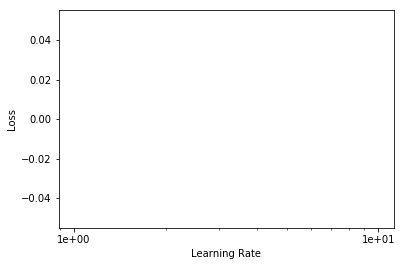

In [132]:
learn.recorder.plot()

In [ ]:
lr = 3e-3 # pick a lr
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
pred = learn.predict(f_test_s)

In [ ]:
learn.save('pd5') # save model
learn.show_results(rows=3, figsize=(8, 9))